In [ ]:
!wget -O movies.csv https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/movies.csv
!wget -O data.csv https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/data.csv

--2023-03-04 07:24:12--  https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/movies.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104093 (102K) [text/plain]
Saving to: ‘movies.csv’

movies.csv          100%[===================>] 101.65K  --.-KB/s    in 0.02s   

2023-03-04 07:24:12 (5.46 MB/s) - ‘movies.csv’ saved [104093/104093]

--2023-03-04 07:24:13--  https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 

In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Method 1: Without Bias

In [ ]:
import numpy as np
import csv
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
def grad_U(Ui, Yij, Vj, reg, eta):
    return eta * (reg * Ui - (Vj * (Yij - np.dot(Ui, Vj))))

def grad_V(Vj, Yij, Ui, reg, eta):
    return eta * (reg * Vj - (Ui * (Yij - np.dot(Ui, Vj))))

def get_err(U, V, Y, reg=0.0):
    sum = 0
    for y in Y:
        (i, j, Y_ij) = y
        sum += (Y_ij - np.dot(U[i-1], V[j-1]))**2
    if reg == 0:
        return (.5 * sum) / len(Y)
    print('no')
    return ((reg / 2) * ((np.linalg.norm(U, ord='fro') ** 2) + (np.linalg.norm(V, ord='fro') ** 2))
            + .5 * sum) / len(Y)

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    U, V = np.random.uniform(-.5, .5, size=(M, K)), np.random.uniform(-.5, .5, size=(N, K))
    init_err = get_err(U, V, Y)
    prev_err = init_err
    for epoch in range(max_epochs):
        idxs = np.random.permutation(len(Y))
        for idx in idxs:
            i, j, Y_ij = Y[idx][0] - 1, Y[idx][1] - 1, Y[idx][2]
            U[i] -= grad_U(U[i], Y_ij, V[j], reg, eta)
            V[j] -= grad_V(V[j], Y_ij, U[i], reg, eta)
        curr_err = get_err(U, V, Y)
        if epoch == 0:
            init_err -= curr_err
            prev_err = curr_err
        else:
            if (prev_err - curr_err) / init_err <= eps:
                break
        prev_err = curr_err
    return (U, V, get_err(U, V, Y))

In [ ]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('data.csv')

# Split the data into training and test sets
train = ratings.sample(n=109351, random_state=1)
test = ratings.drop(train.index)

n_users = train['User ID'].nunique()
n_movies = movies.shape[0]

# Convert the data to the required format
train_data = train[['User ID', 'Movie ID', 'Rating']].to_numpy()
test_data = test[['User ID', 'Movie ID', 'Rating']].to_numpy()

# Save the data to CSV files
np.savetxt('train_data.csv', train_data, delimiter=',', fmt='%d, %d, %.1f')
np.savetxt('test_data.csv', test_data, delimiter=',', fmt='%d, %d, %.1f')

Y_train = np.array(train).astype(int)
Y_test = np.array(test).astype(int)

user_ids = np.concatenate((Y_train[:,0], Y_test[:,0]), axis=0)
movie_ids = np.concatenate((Y_train[:,1], Y_test[:,1]), axis=0)
num_users = max(user_ids).astype(int)
num_movies = max(movie_ids).astype(int)

num_factors = 20
regularization_param = 0.0
learning_rate = 0.03
E_in = []
E_out = []
U,V, err = train_model(num_users, num_movies, num_factors, learning_rate, regularization_param, Y_train)
E_in.append(err)
E_out.append(get_err(U, V, Y_test, regularization_param))
print(f"E_out = {E_out[0]}")



E_out = 0.593667305930746


In [ ]:
A = np.linalg.svd(V.transpose())[0]
V_tilde = np.dot(A[:, :2].transpose(), V.transpose())
U_tilde = np.dot(A[:, :2].transpose(), U.transpose())
for i in range(len(V_tilde)):
  V_tilde[i] -= np.mean(V_tilde[i])
  V_tilde[i] /= np.std(V_tilde[i])
  U_tilde[i] -= np.mean(V_tilde[i])
  U_tilde[i] /= np.std(V_tilde[i])


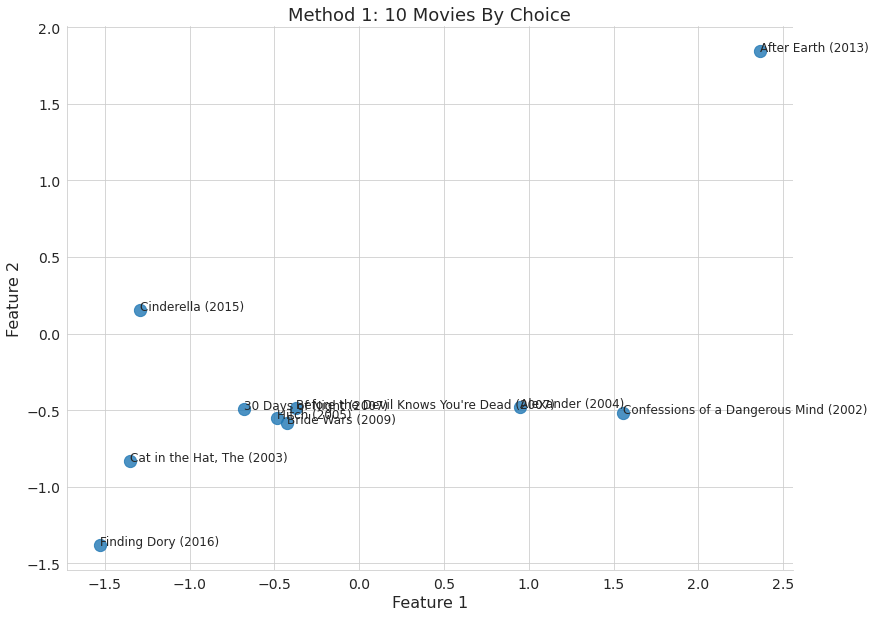

In [ ]:
# Plot 10 movies of our choice
movie_names = np.array(movies)[:,1]
movie_indices = [54, 24, 444, 51, 141, 581, 191, 230, 253, 273]
movie_labels = movie_names[movie_indices]

# Extract the corresponding columns from V_tilde for the 10 movies
movie_coordinates = V_tilde[:, movie_indices]

import seaborn as sns

# Define the plot style
sns.set_style("whitegrid")

# Define the plot dimensions
fig, ax = plt.subplots(figsize=(13, 10))
ax.scatter(movie_coordinates[0], movie_coordinates[1], s=150, alpha=0.8)
ax.set_xlabel("Feature 1", fontsize=16)
ax.set_ylabel("Feature 2", fontsize=16)
ax.set_title("Method 1: 10 Movies By Choice", fontsize=18)
for i, label in enumerate(movie_labels):
    ax.annotate(label, (movie_coordinates[0][i], movie_coordinates[1][i]), fontsize=12)
ax.tick_params(labelsize=14)
sns.despine()
plt.show()



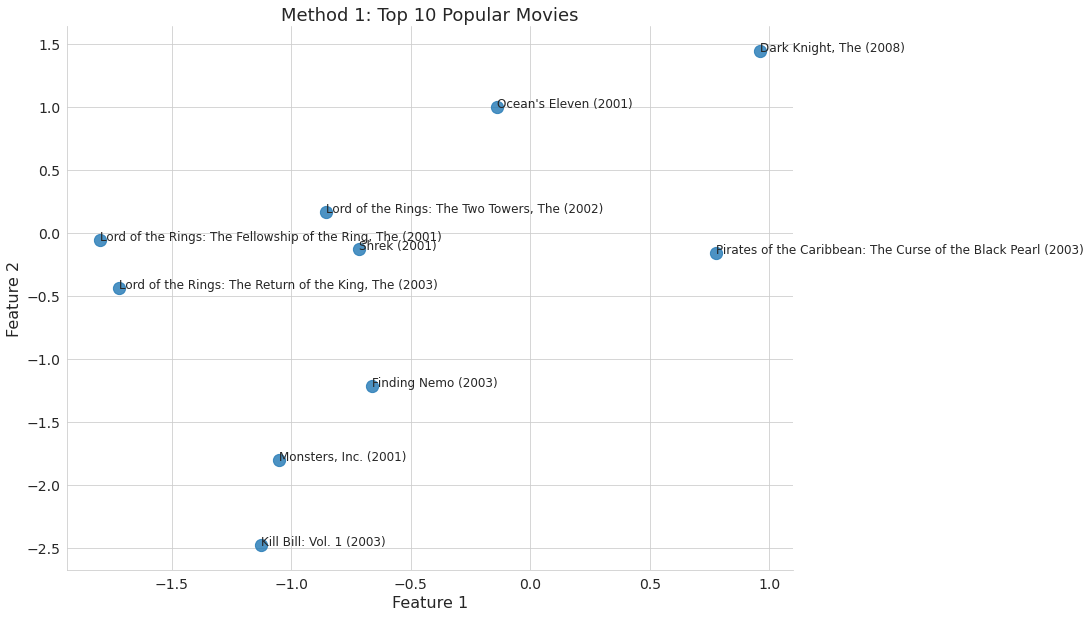

In [ ]:
# 10 most popular movies (by most ratings)
popular = np.array(ratings["Movie ID"].value_counts().nlargest(10).index)
movie_names = np.array(movies)[:,1]
movie_indices = [idx for idx in popular]
movie_coordinates = V_tilde[:, movie_indices]
movie_labels = movie_names[movie_indices]

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(13, 10))
ax.scatter(movie_coordinates[0], movie_coordinates[1], s=150, alpha=0.8)
ax.set_xlabel("Feature 1", fontsize=16)
ax.set_ylabel("Feature 2", fontsize=16)
ax.set_title("Method 1: Top 10 Popular Movies", fontsize=18)
for i, label in enumerate(movie_labels):
    ax.annotate(label, (movie_coordinates[0][i], movie_coordinates[1][i]), fontsize=12)
ax.tick_params(labelsize=14)
sns.despine()
plt.show()

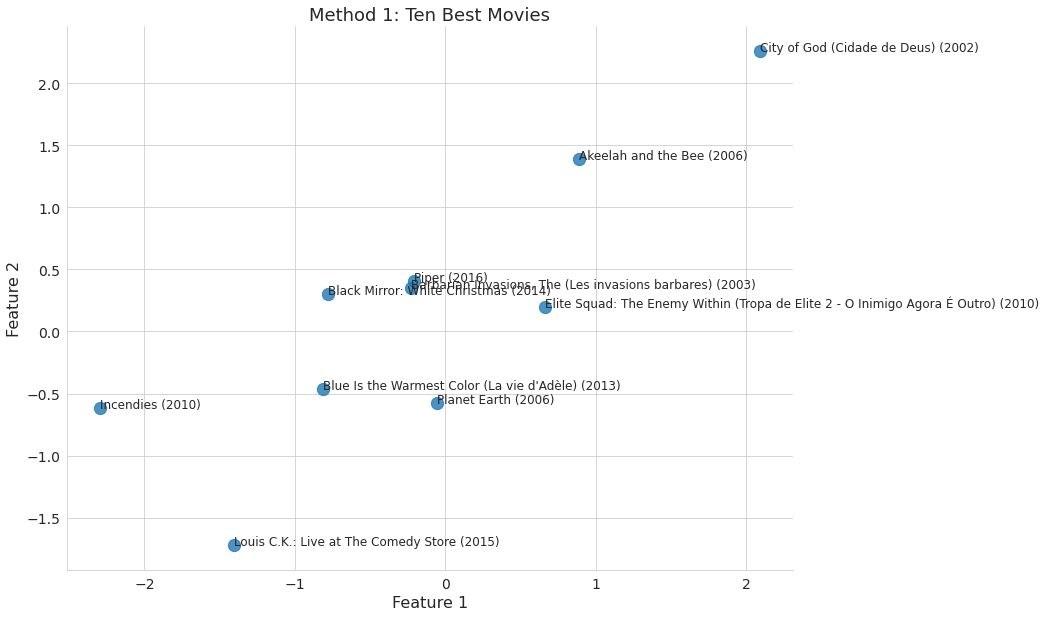

In [ ]:
# The ten best movies (movies with the highest average ratings)
best_movies = ratings.groupby(by='Movie ID').mean().sort_values(by=['Rating'], ascending=False).nlargest(10, "Rating").index
movie_names = np.array(movies)[:,1]
movie_indices = [idx for idx in best_movies]
movie_coordinates = V_tilde[:, movie_indices]
movie_labels = movie_names[movie_indices]

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(13, 10))
ax.scatter(movie_coordinates[0], movie_coordinates[1], s=150, alpha=0.8)
ax.set_xlabel("Feature 1", fontsize=16)
ax.set_ylabel("Feature 2", fontsize=16)
ax.set_title("Method 1: Ten Best Movies", fontsize=18)
for i, label in enumerate(movie_labels):
    ax.annotate(label, (movie_coordinates[0][i], movie_coordinates[1][i]), fontsize=12)
ax.tick_params(labelsize=14)
sns.despine()
plt.show()

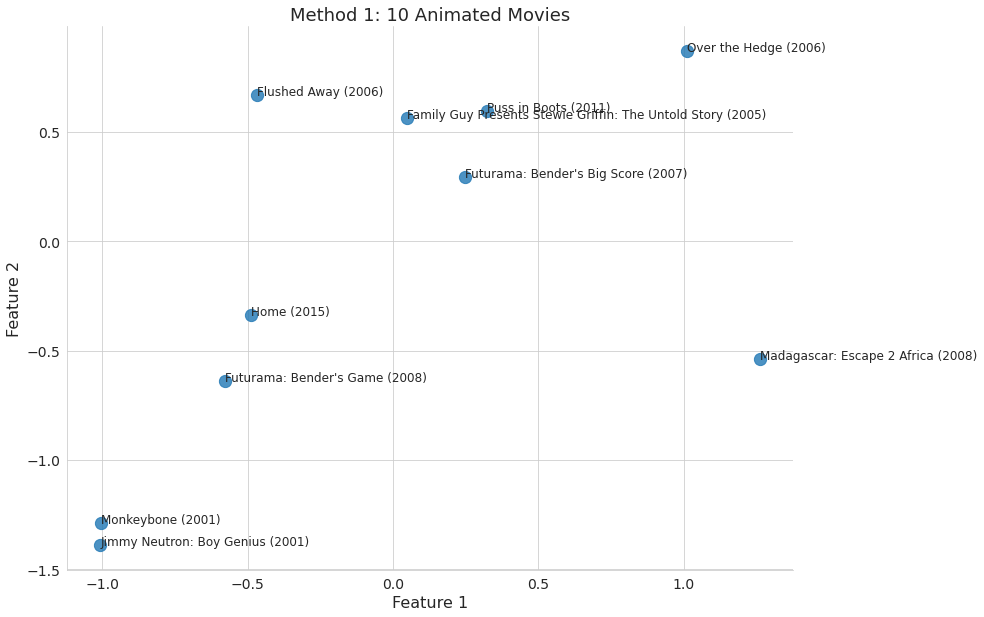

In [ ]:
# Ten random Animated Movies
import random
movies = pd.read_csv('https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/movies.csv')
animated = np.array(movies[movies['Animation']==1]['Movie ID'])
animated = animated[random.sample(range(0, len(animated)), 10)]

movie_names = np.array(movies)[:,1]
movie_indices = [idx for idx in animated]
movie_coordinates = V_tilde[:, movie_indices]
movie_labels = movie_names[movie_indices]
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(13, 10))
ax.scatter(movie_coordinates[0], movie_coordinates[1], s=150, alpha=0.8)
ax.set_xlabel("Feature 1", fontsize=16)
ax.set_ylabel("Feature 2", fontsize=16)
ax.set_title("Method 1: 10 Animated Movies", fontsize=18)
for i, label in enumerate(movie_labels):
    ax.annotate(label, (movie_coordinates[0][i], movie_coordinates[1][i]), fontsize=12)
ax.tick_params(labelsize=14)
sns.despine()
plt.show()

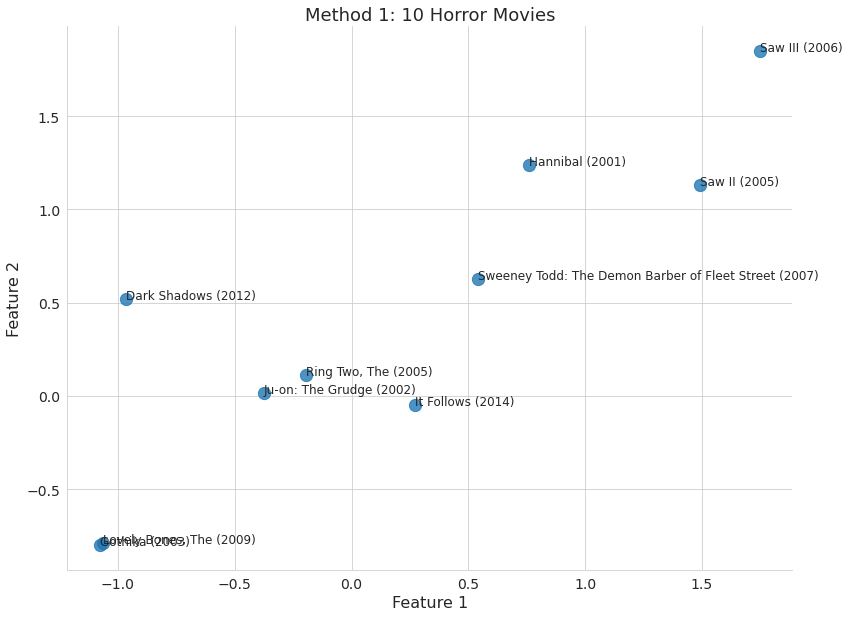

In [ ]:
# Ten Random Horror Movies
horror = np.array(movies[movies['Horror']==1]['Movie ID'])
horror = horror[random.sample(range(0, len(horror)), 10)]

movie_names = np.array(movies)[:,1]
movie_indices = [idx for idx in horror]
movie_coordinates = V_tilde[:, movie_indices]
movie_labels = movie_names[movie_indices]
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(13, 10))
ax.scatter(movie_coordinates[0], movie_coordinates[1], s=150, alpha=0.8)
ax.set_xlabel("Feature 1", fontsize=16)
ax.set_ylabel("Feature 2", fontsize=16)
ax.set_title("Method 1: 10 Horror Movies", fontsize=18)
for i, label in enumerate(movie_labels):
    ax.annotate(label, (movie_coordinates[0][i], movie_coordinates[1][i]), fontsize=12)
ax.tick_params(labelsize=14)
sns.despine()
plt.show()

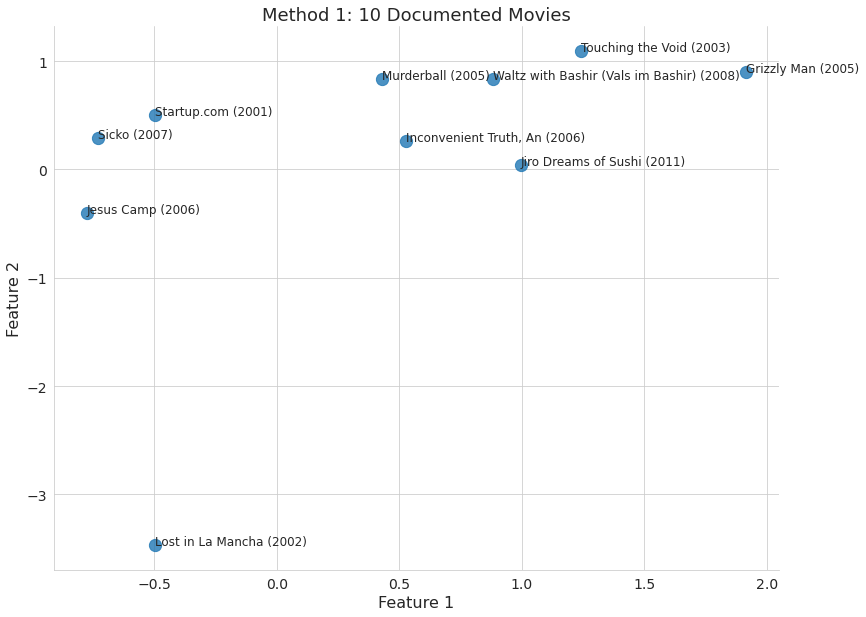

In [ ]:
# Ten random Documentary Movies
documentary = np.array(movies[movies['Documentary']==1]['Movie ID'])
documentary = documentary[random.sample(range(0, len(documentary)), 10)]

movie_names = np.array(movies)[:,1]
movie_indices = [idx for idx in documentary]
movie_coordinates = V_tilde[:, movie_indices]
movie_labels = movie_names[movie_indices]
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(13, 10))
ax.scatter(movie_coordinates[0], movie_coordinates[1], s=150, alpha=0.8)
ax.set_xlabel("Feature 1", fontsize=16)
ax.set_ylabel("Feature 2", fontsize=16)
ax.set_title("Method 1: 10 Documented Movies", fontsize=18)
for i, label in enumerate(movie_labels):
    ax.annotate(label, (movie_coordinates[0][i], movie_coordinates[1][i]), fontsize=12)
ax.tick_params(labelsize=14)
sns.despine()
plt.show()

Method Two: Surpise SVD With Bias

In [ ]:
import surprise
from surprise import SVD, accuracy
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from surprise import Dataset, Reader
import surprise
import numpy as np
import csv
import random
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

In [ ]:
!wget -O movies.csv https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/movies.csv
!wget -O data.csv https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/data.csv

--2023-03-03 21:05:37--  https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/movies.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104093 (102K) [text/plain]
Saving to: ‘movies.csv’

movies.csv          100%[===================>] 101.65K  --.-KB/s    in 0.007s  

2023-03-03 21:05:37 (13.7 MB/s) - ‘movies.csv’ saved [104093/104093]

--2023-03-03 21:05:37--  https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 

In [ ]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('data.csv')

# Split the data into training and test sets
train = ratings.sample(n=109351, random_state=1)
test = ratings.drop(train.index)

n_users = train['User ID'].nunique()
n_movies = movies.shape[0]

# Convert the data to the required format
train_data = train[['User ID', 'Movie ID', 'Rating']]
test_data = test[['User ID', 'Movie ID', 'Rating']]
# Save the data to CSV files
np.savetxt('train_data.csv', train_data, delimiter=',', fmt='%d, %d, %.1f')
np.savetxt('test_data.csv', test_data, delimiter=',', fmt='%d, %d, %.1f')

reader = Reader(sep=',')
data = Dataset.load_from_df(ratings, reader)
test = Dataset.load_from_df(test_data, reader)
train = Dataset.load_from_df(train_data, reader)
train = train.build_full_trainset()
algo = SVD(n_factors=20, n_epochs=100, biased=True)
algo.fit(train)
U = algo.pu
V = algo.qi
user_bias = algo.bu
movie_bias = algo.bi

In [ ]:
def get_err(Y, algo, reg=0.0):
    sum = 0
    for y in Y:
        (i, j, Y_ij) = y
        sum += (Y_ij - algo.predict(uid=i, iid=j)[3])**2
    return (.5 * sum) / len(Y)

In [ ]:
print('E_out= ', get_err(np.loadtxt('test_data.csv', skiprows=1, delimiter=','), algo, 0))

E_out=  0.3754717791995917


In [ ]:
# Latent Factors
A, S, B = np.linalg.svd(np.transpose(V))
proj = np.transpose(A[:, :2])
V_proj = np.dot(proj, np.transpose(V))
U_proj = np.dot(proj, np.transpose(U))

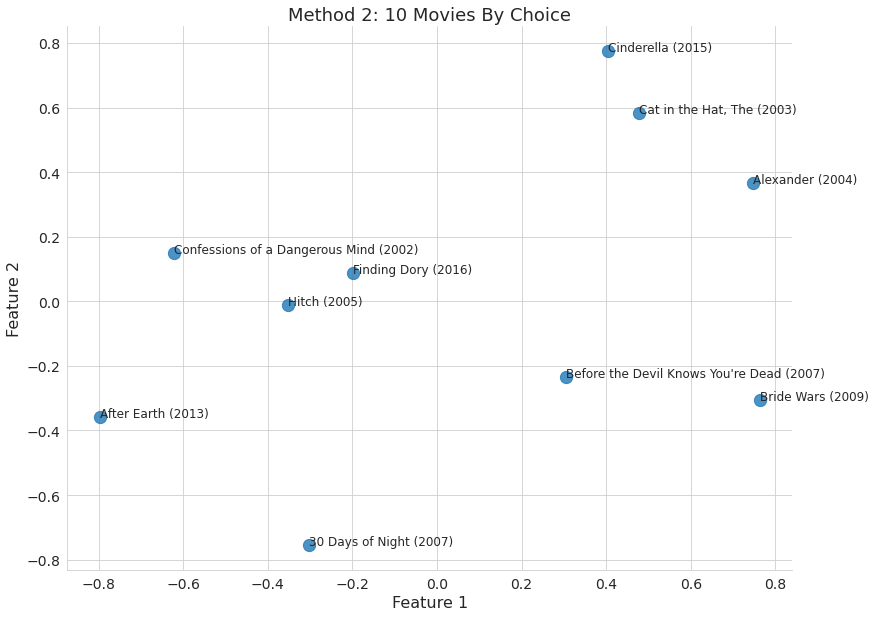

In [ ]:
# Plot 10 movies of our choice
titles = np.array(movies)[:,1]
indices = [54, 24, 444, 51, 141, 581, 191, 230, 253, 273]
labels = titles[indices]
# Extract the corresponding columns from V_proj for the 10 movies
coordinates = V_proj[:, indices]
# plot style
sns.set_style("whitegrid")
# Define the plot dimensions
fig, ax = plt.subplots(figsize=(13, 10))
ax.scatter(coordinates[0], coordinates[1], s=150, alpha=0.8)
ax.set_xlabel("Feature 1", fontsize=16)
ax.set_ylabel("Feature 2", fontsize=16)
ax.set_title("Method 2: 10 Movies By Choice", fontsize=18)
for i, label in enumerate(labels):
    ax.annotate(label, (coordinates[0][i], coordinates[1][i]), fontsize=12)
ax.tick_params(labelsize=14)
sns.despine()
plt.show()

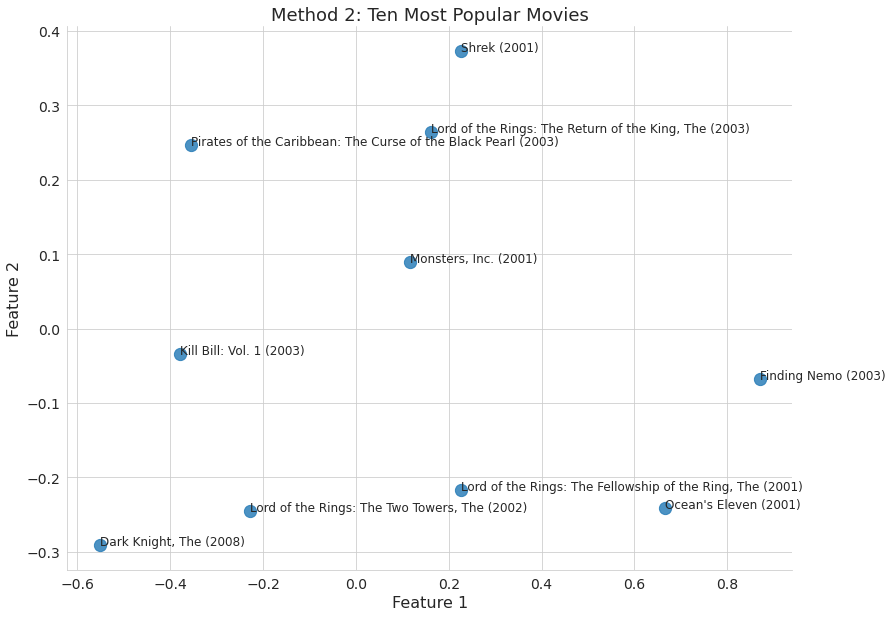

In [ ]:
# 10 most popular movies (by most ratings)
popular = np.array(ratings["Movie ID"].value_counts().nlargest(10).index)
titles = np.array(movies)[:,1]
indices = [idx for idx in popular]
coordinates = V_proj[:, indices]
labels = titles[indices]
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(13, 10))
ax.scatter(coordinates[0], coordinates[1], s=150, alpha=0.8)
ax.set_xlabel("Feature 1", fontsize=16)
ax.set_ylabel("Feature 2", fontsize=16)
ax.set_title("Method 2: Ten Most Popular Movies", fontsize=18)
for i, label in enumerate(labels):
    ax.annotate(label, (coordinates[0][i], coordinates[1][i]), fontsize=12)
ax.tick_params(labelsize=14)
sns.despine()
plt.show()

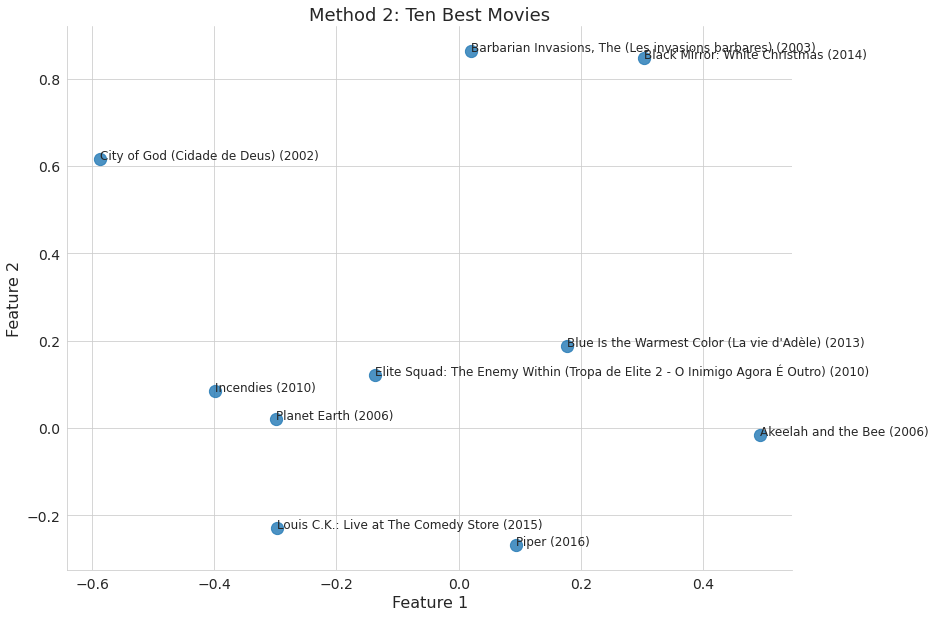

In [ ]:
# The ten best movies (movies with the highest average ratings)
best_movies = ratings.groupby(by='Movie ID').mean().sort_values(by=['Rating'], ascending=False).nlargest(10, "Rating").index
titles = np.array(movies)[:,1]
indices = [idx for idx in best_movies]
coordinates = V_proj[:, indices]
labels = titles[indices]
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(13, 10))
ax.scatter(coordinates[0], coordinates[1], s=150, alpha=0.8)
ax.set_xlabel("Feature 1", fontsize=16)
ax.set_ylabel("Feature 2", fontsize=16)
ax.set_title("Method 2: Ten Best Movies", fontsize=18)
for i, label in enumerate(labels):
    ax.annotate(label, (coordinates[0][i], coordinates[1][i]), fontsize=12)
ax.tick_params(labelsize=14)
sns.despine()
plt.show()

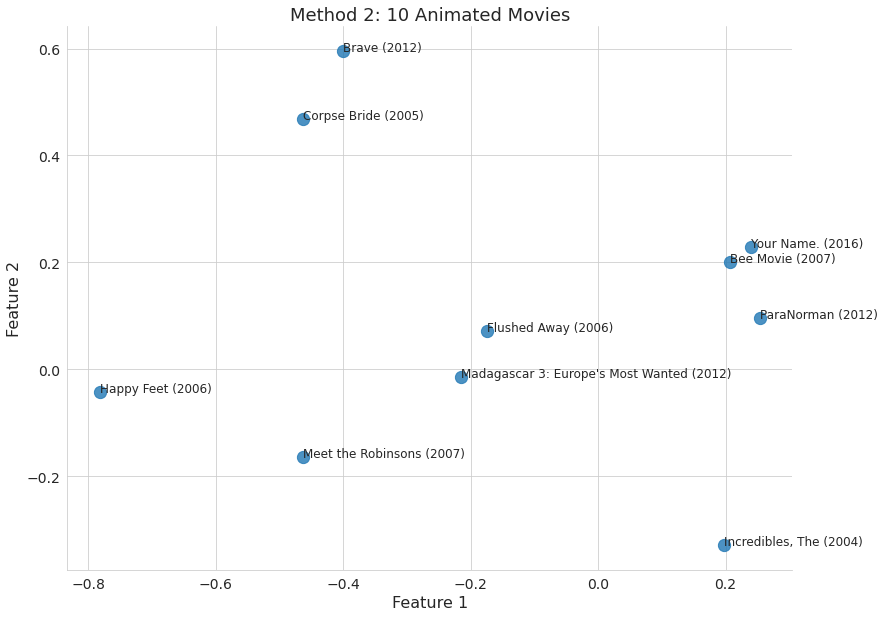

In [ ]:
# Ten random Animated Movies
import random
movies = pd.read_csv('https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject2/data/movies.csv')
animated = np.array(movies[movies['Animation']==1]['Movie ID'])
animated = animated[random.sample(range(0, len(animated)), 10)]
titles = np.array(movies)[:,1]
indices = [idx for idx in animated]
coordinates = V_proj[:, indices]
labels = titles[indices]
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(13, 10))
ax.scatter(coordinates[0], coordinates[1], s=150, alpha=0.8)
ax.set_xlabel("Feature 1", fontsize=16)
ax.set_ylabel("Feature 2", fontsize=16)
ax.set_title("Method 2: 10 Animated Movies", fontsize=18)
for i, label in enumerate(labels):
    ax.annotate(label, (coordinates[0][i], coordinates[1][i]), fontsize=12)
ax.tick_params(labelsize=14)
sns.despine()
plt.show()

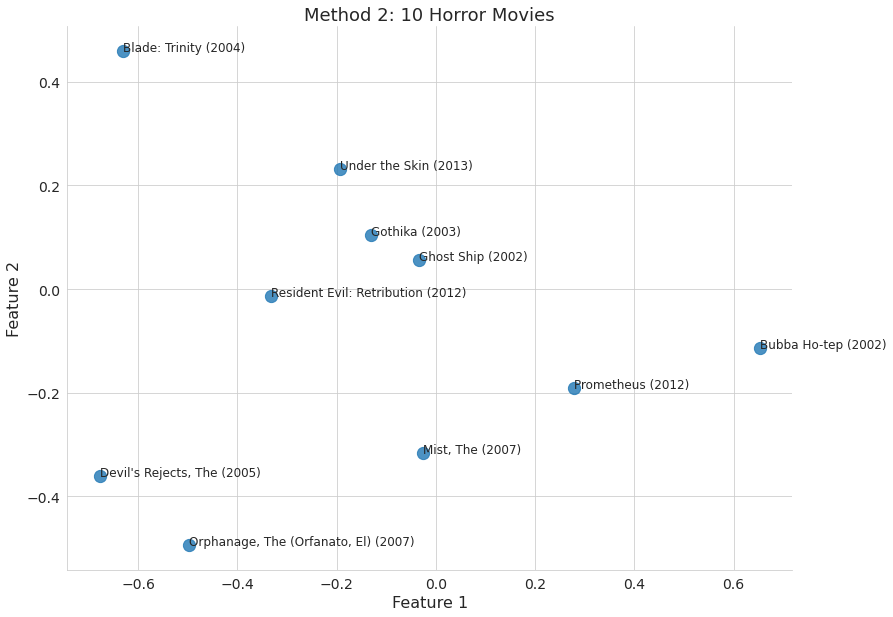

In [ ]:
# Ten Random Horror Movies
horror = np.array(movies[movies['Horror']==1]['Movie ID'])
horror = horror[random.sample(range(0, len(horror)), 10)]
titles = np.array(movies)[:,1]
indices = [idx for idx in horror]
coordinates = V_proj[:, indices]
labels = titles[indices]
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(13, 10))
ax.scatter(coordinates[0], coordinates[1], s=150, alpha=0.8)
ax.set_xlabel("Feature 1", fontsize=16)
ax.set_ylabel("Feature 2", fontsize=16)
ax.set_title("Method 2: 10 Horror Movies", fontsize=18)
for i, label in enumerate(labels):
    ax.annotate(label, (coordinates[0][i], coordinates[1][i]), fontsize=12)
ax.tick_params(labelsize=14)
sns.despine()
plt.show()

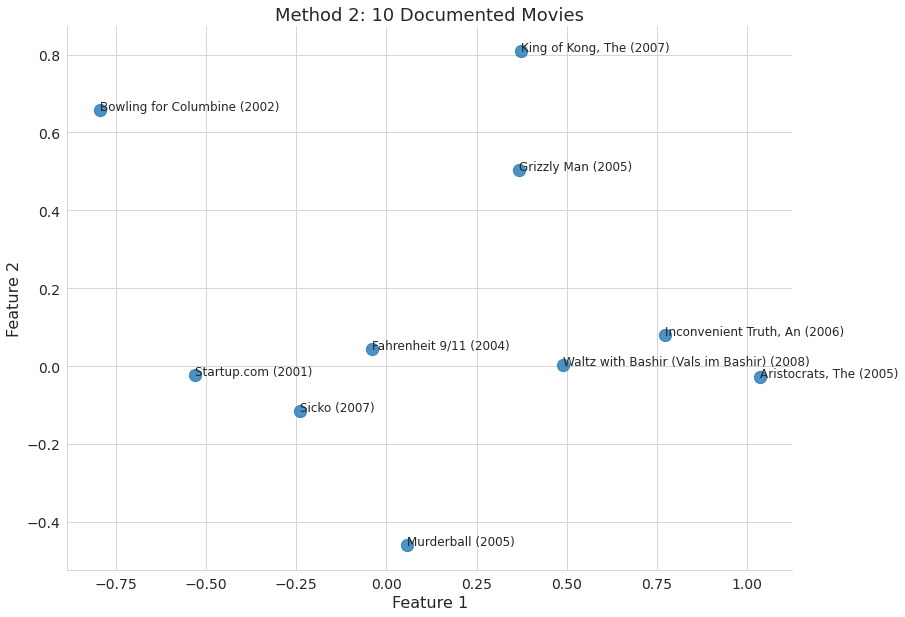

In [ ]:
# Ten random Documentary Movies
documentary = np.array(movies[movies['Documentary']==1]['Movie ID'])
documentary = documentary[random.sample(range(0, len(documentary)), 10)]
titles = np.array(movies)[:,1]
indices = [idx for idx in documentary]
coordinates = V_proj[:, indices]
labels = titles[indices]
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(13, 10))
ax.scatter(coordinates[0], coordinates[1], s=150, alpha=0.8)
ax.set_xlabel("Feature 1", fontsize=16)
ax.set_ylabel("Feature 2", fontsize=16)
ax.set_title("Method 2: 10 Documented Movies", fontsize=18)
for i, label in enumerate(labels):
    ax.annotate(label, (coordinates[0][i], coordinates[1][i]), fontsize=12)
ax.tick_params(labelsize=14)
sns.despine()
plt.show()

Off-The-Shelf Implementation (Surprise SVD)

In [ ]:
!pip3 install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=3366550 sha256=369653ca27730cdd0b83999451760d1f6494382c73478188ff54d4d4ed8c6eff
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [ ]:
# from surprise official documentation
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

reader = Reader()
train_surprise = Dataset.load_from_df(train, reader)
algo = SVD()
train_surprise = train_surprise.build_full_trainset()
algo.fit(train_surprise)
V_tilde_surprise = algo.qi.T

In [ ]:
# splitting the data 5-fold cross-validation, and computing the MAE & MSE of the SVD algorithm.
data = Dataset.load_from_df(ratings, reader)
algo = SVD()
cross_validate(algo, data, measures=['MSE', 'MAE'], cv=5, verbose=True)

Evaluating MSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MSE (testset)     0.6981  0.6956  0.6804  0.6906  0.7145  0.6958  0.0111  
MAE (testset)     0.6298  0.6272  0.6236  0.6237  0.6328  0.6274  0.0036  
Fit time          2.67    6.31    5.70    6.71    2.62    4.80    1.79    
Test time         0.28    0.93    0.66    0.91    0.25    0.61    0.29    


{'test_mse': array([0.69807489, 0.69557453, 0.68044317, 0.69061506, 0.71447935]),
 'test_mae': array([0.62977423, 0.62720323, 0.62360918, 0.6236501 , 0.63284717]),
 'fit_time': (2.6700327396392822,
  6.309794187545776,
  5.702027797698975,
  6.714071273803711,
  2.623215675354004),
 'test_time': (0.27872395515441895,
  0.9337468147277832,
  0.6639940738677979,
  0.9078464508056641,
  0.25247621536254883)}

In [ ]:
# splitting the data 10-fold cross-validation, and computing the MAE & MSE of the SVD algorithm.
algo = SVD()
cross_validate(algo, data, measures=['MSE', 'MAE'], cv=10, verbose=True)

Evaluating MSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
MSE (testset)     0.6853  0.6949  0.6869  0.6690  0.6724  0.6888  0.7121  0.6885  0.6852  0.6635  0.6847  0.0132  
MAE (testset)     0.6214  0.6241  0.6219  0.6151  0.6197  0.6226  0.6339  0.6223  0.6228  0.6121  0.6216  0.0054  
Fit time          3.23    2.77    2.61    2.53    3.32    2.67    2.54    2.51    3.34    2.69    2.82    0.32    
Test time         0.30    0.14    0.25    0.13    0.24    0.13    0.16    0.13    0.25    0.27    0.20    0.06    


{'test_mse': array([0.68527485, 0.69490054, 0.68691852, 0.66895499, 0.67242016,
        0.6888178 , 0.7121351 , 0.68850092, 0.68520591, 0.66354079]),
 'test_mae': array([0.62138307, 0.62408366, 0.62186041, 0.61511892, 0.61972755,
        0.62264637, 0.63394888, 0.62226235, 0.62278485, 0.61213111]),
 'fit_time': (3.2330501079559326,
  2.7727255821228027,
  2.6081442832946777,
  2.5314764976501465,
  3.315504550933838,
  2.6676793098449707,
  2.543593645095825,
  2.511488199234009,
  3.3414525985717773,
  2.6907851696014404),
 'test_time': (0.3049607276916504,
  0.14099335670471191,
  0.25426793098449707,
  0.1320512294769287,
  0.23558521270751953,
  0.12735986709594727,
  0.1583867073059082,
  0.13332819938659668,
  0.24515175819396973,
  0.2694103717803955)}

In [ ]:
# splitting the data 20-fold cross-validation, and computing the MAE & MSE of the SVD algorithm.
algo = SVD()
cross_validate(algo, data, measures=['MSE', 'MAE'], cv=20, verbose=True)

Evaluating MSE, MAE of algorithm SVD on 20 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Fold 11 Fold 12 Fold 13 Fold 14 Fold 15 Fold 16 Fold 17 Fold 18 Fold 19 Fold 20 Mean    Std     
MSE (testset)     0.6776  0.6718  0.6943  0.6929  0.6945  0.6676  0.6773  0.6694  0.6917  0.6822  0.6589  0.6867  0.7066  0.6815  0.6616  0.7001  0.6822  0.7047  0.6447  0.6946  0.6820  0.0158  
MAE (testset)     0.6188  0.6144  0.6246  0.6274  0.6238  0.6105  0.6191  0.6172  0.6229  0.6238  0.6067  0.6207  0.6286  0.6192  0.6130  0.6316  0.6210  0.6288  0.6065  0.6235  0.6201  0.0069  
Fit time          3.55    2.83    4.00    2.76    2.73    2.87    3.62    2.78    2.78    3.30    3.11    2.75    2.75    3.72    2.75    2.75    2.78    3.96    2.74    2.72    3.06    0.44    
Test time         0.08    0.20    0.07    0.06    0.09    0.13    0.07    0.08    0.07    0.29    0.07    0.07    0.07    0.11    0.07    0.06    0.07    0.08    0.07

{'test_mse': array([0.67757783, 0.67178827, 0.69434469, 0.6928528 , 0.6944611 ,
        0.66762197, 0.67733782, 0.66944434, 0.69169516, 0.68215574,
        0.65894908, 0.68667278, 0.70660039, 0.68154548, 0.66159498,
        0.70008172, 0.68224467, 0.70467122, 0.64472968, 0.69459543]),
 'test_mae': array([0.61877032, 0.61439106, 0.62460257, 0.62742716, 0.62381877,
        0.61054437, 0.61906085, 0.61722836, 0.62294998, 0.62381835,
        0.60671631, 0.62068758, 0.62860901, 0.61919323, 0.6129944 ,
        0.63162918, 0.62102229, 0.62877569, 0.60647711, 0.62347376]),
 'fit_time': (3.5501275062561035,
  2.8258042335510254,
  4.001298427581787,
  2.7603116035461426,
  2.7303779125213623,
  2.873462677001953,
  3.6245601177215576,
  2.7800710201263428,
  2.7849130630493164,
  3.3021697998046875,
  3.1074166297912598,
  2.7518973350524902,
  2.7493653297424316,
  3.7164862155914307,
  2.751317024230957,
  2.750247001647949,
  2.775038003921509,
  3.9598588943481445,
  2.739755868911743,
  2.

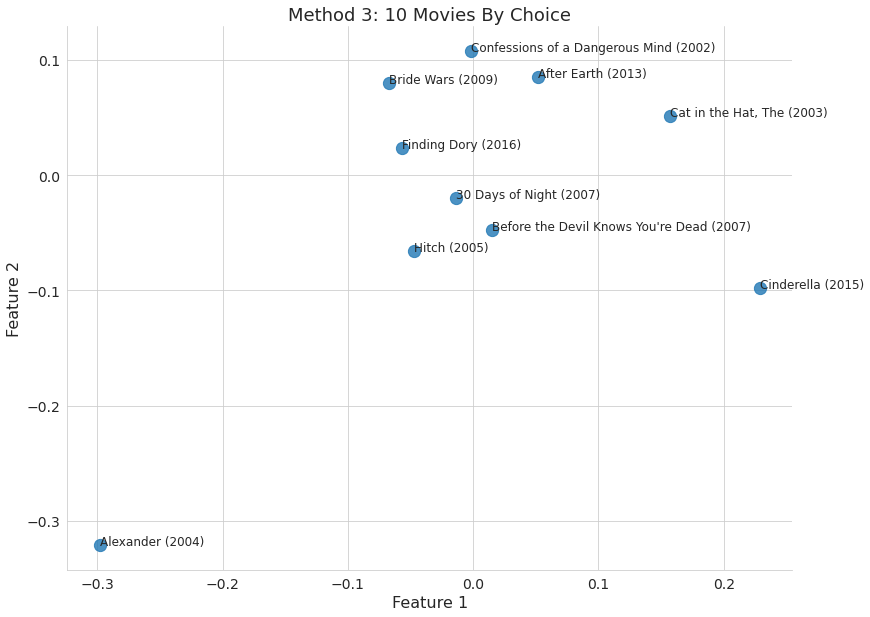

In [ ]:
# Plot 10 movies of our choice
name = np.array(movies)[:,1]
index = [54, 24, 444, 51, 141, 581, 191, 230, 253, 273]
label = name[index]

# Extract the corresponding columns from V_tilde for the 10 movies
coors = V_tilde_surprise[:, index]

import seaborn as sns

# Define the plot style
sns.set_style("whitegrid")

# Define the plot dimensions
fig, ax = plt.subplots(figsize=(13, 10))
ax.scatter(coors[0], coors[1], s=150, alpha=0.8)
ax.set_xlabel("Feature 1", fontsize=16)
ax.set_ylabel("Feature 2", fontsize=16)
ax.set_title("Method 3: 10 Movies By Choice", fontsize=18)
for i, label in enumerate(label):
    ax.annotate(label, (coors[0][i], coors[1][i]), fontsize=12)
ax.tick_params(labelsize=14)
sns.despine()
plt.show()

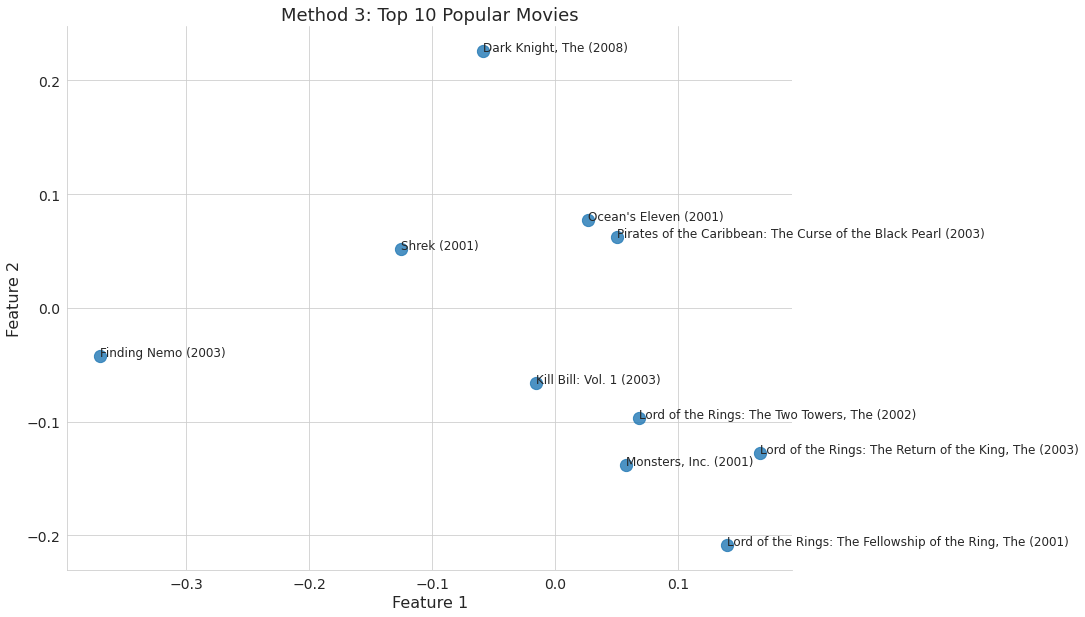

In [ ]:
# 10 most popular movies (by most ratings)
popular = np.array(ratings["Movie ID"].value_counts().nlargest(10).index)
name = np.array(movies)[:,1]
index = [idx for idx in popular]
coors = V_tilde_surprise[:, index]
label = name[index]

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(13, 10))
ax.scatter(coors[0], coors[1], s=150, alpha=0.8)
ax.set_xlabel("Feature 1", fontsize=16)
ax.set_ylabel("Feature 2", fontsize=16)
ax.set_title("Method 3: Top 10 Popular Movies", fontsize=18)
for i, label in enumerate(label):
    ax.annotate(label, (coors[0][i], coors[1][i]), fontsize=12)
ax.tick_params(labelsize=14)
sns.despine()
plt.show()

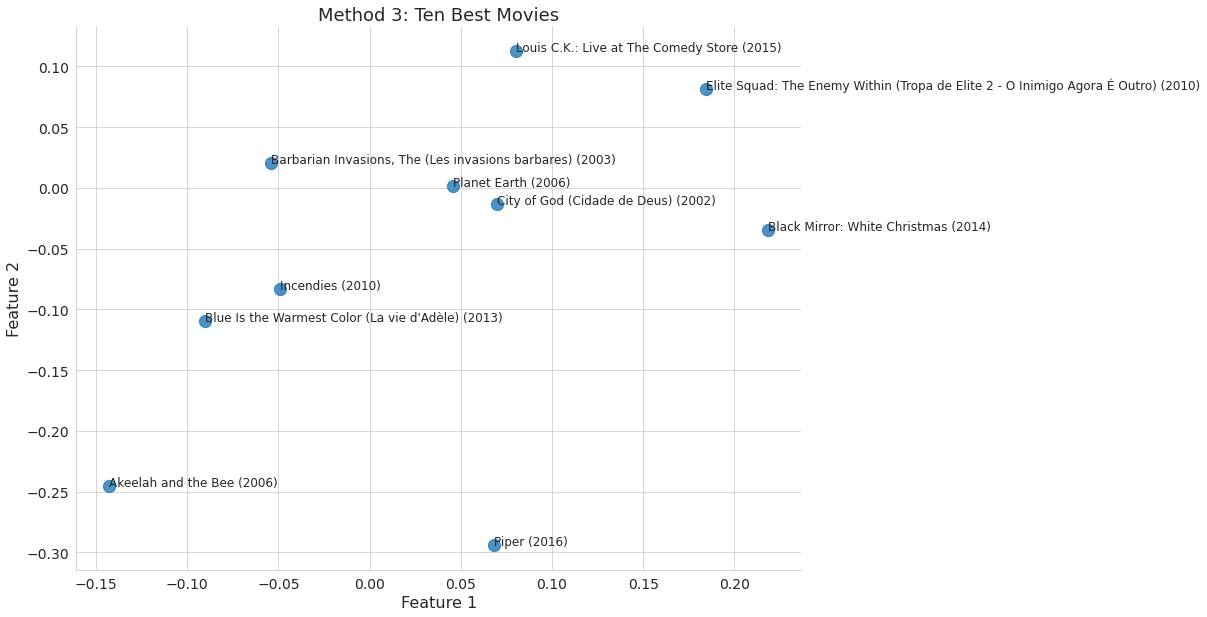

In [ ]:
# The ten best movies (movies with the highest average ratings)
best = ratings.groupby(by='Movie ID').mean().sort_values(by=['Rating'], ascending=False).nlargest(10, "Rating").index
name = np.array(movies)[:,1]
index = [idx for idx in best]
coors = V_tilde_surprise[:, index]
label = name[index]

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(13, 10))
ax.scatter(coors[0], coors[1], s=150, alpha=0.8)
ax.set_xlabel("Feature 1", fontsize=16)
ax.set_ylabel("Feature 2", fontsize=16)
ax.set_title("Method 3: Ten Best Movies", fontsize=18)
for i, label in enumerate(label):
    ax.annotate(label, (coors[0][i], coors[1][i]), fontsize=12)
ax.tick_params(labelsize=14)
sns.despine()
plt.show()

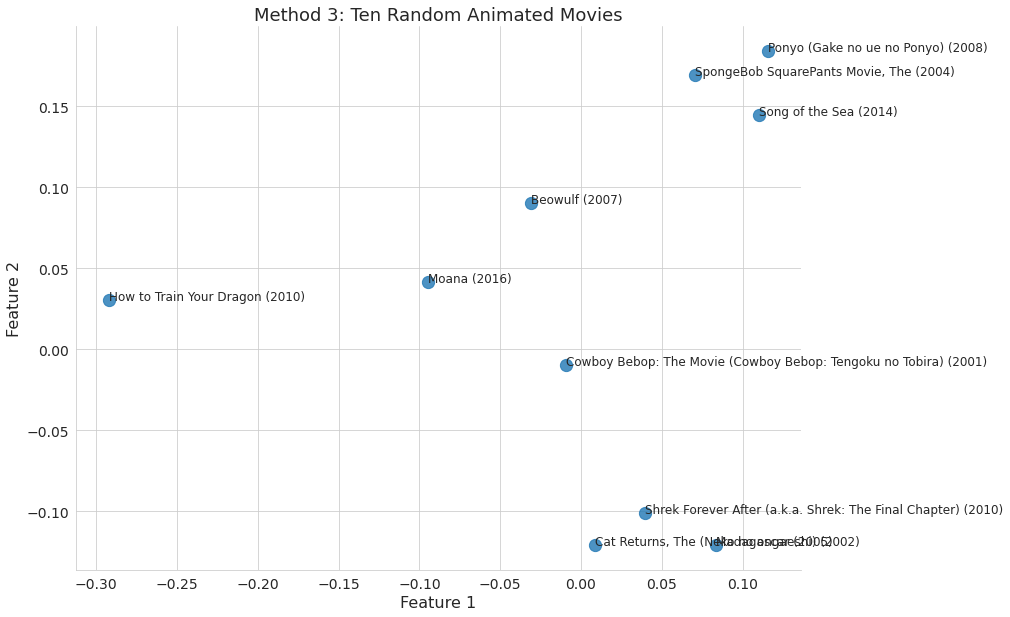

In [ ]:
# Ten random Animated Movies
import random
animated = np.array(movies[movies['Animation']==1]['Movie ID'])
animated = animated[random.sample(range(0, len(animated)), 10)]
name = np.array(movies)[:,1]
index = [idx for idx in animated]
coors = V_tilde_surprise[:, index]
label = name[index]

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(13, 10))
ax.scatter(coors[0], coors[1], s=150, alpha=0.8)
ax.set_xlabel("Feature 1", fontsize=16)
ax.set_ylabel("Feature 2", fontsize=16)
ax.set_title("Method 3: Ten Random Animated Movies", fontsize=18)
for i, label in enumerate(label):
    ax.annotate(label, (coors[0][i], coors[1][i]), fontsize=12)
ax.tick_params(labelsize=14)
sns.despine()
plt.show()

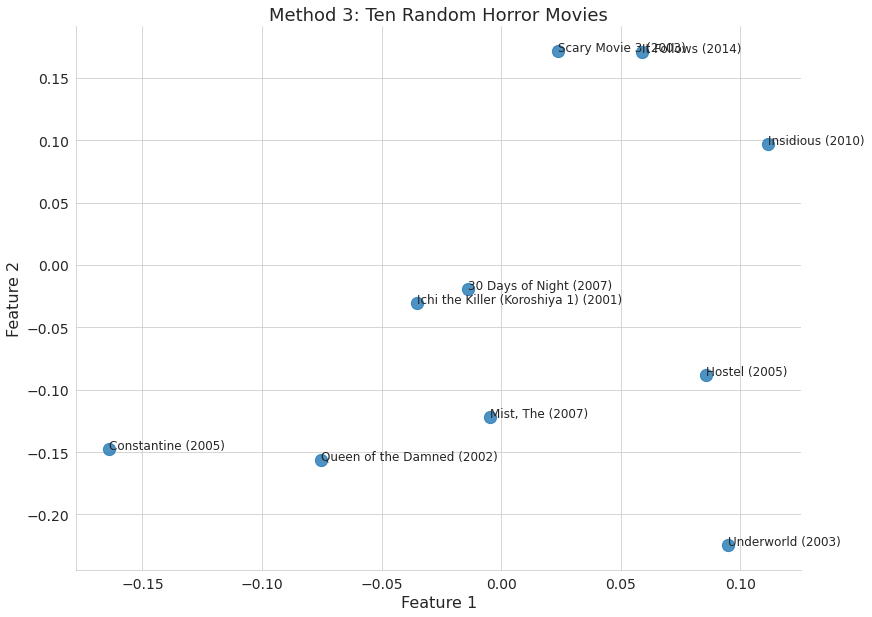

In [ ]:
# Ten Random Horror Movies
horror = np.array(movies[movies['Horror']==1]['Movie ID'])
horror = horror[random.sample(range(0, len(horror)), 10)]
name = np.array(movies)[:,1]
index = [idx for idx in horror]
coors = V_tilde_surprise[:, index]
label = name[index]

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(13, 10))
ax.scatter(coors[0], coors[1], s=150, alpha=0.8)
ax.set_xlabel("Feature 1", fontsize=16)
ax.set_ylabel("Feature 2", fontsize=16)
ax.set_title("Method 3: Ten Random Horror Movies", fontsize=18)
for i, label in enumerate(label):
    ax.annotate(label, (coors[0][i], coors[1][i]), fontsize=12)
ax.tick_params(labelsize=14)
sns.despine()
plt.show()

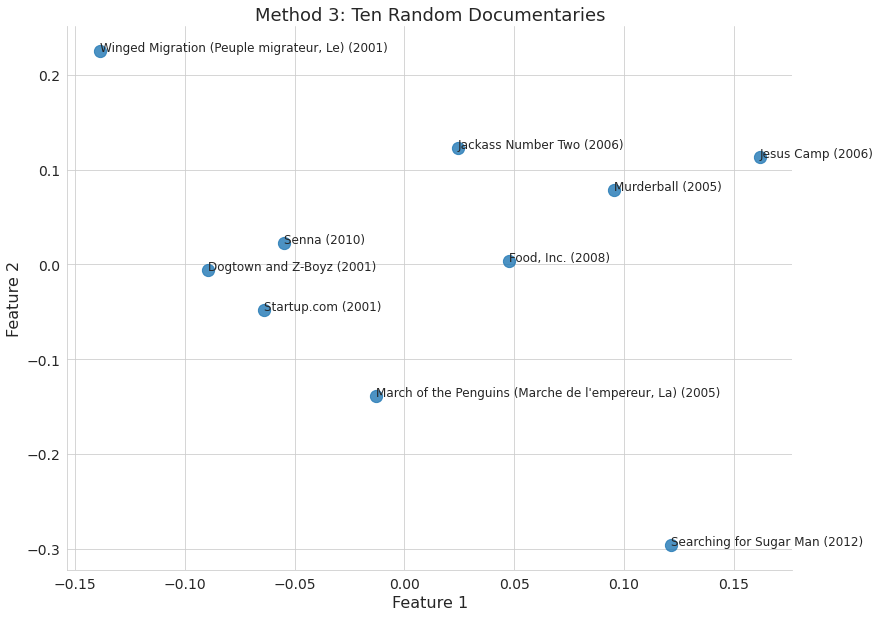

In [ ]:
# Ten random Documentary Movies
documentary = np.array(movies[movies['Documentary']==1]['Movie ID'])
documentary = documentary[random.sample(range(0, len(documentary)), 10)]
name = np.array(movies)[:,1]
index = [idx for idx in documentary]
coors = V_tilde_surprise[:, index]
label = name[index]

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(13, 10))
ax.scatter(coors[0], coors[1], s=150, alpha=0.8)
ax.set_xlabel("Feature 1", fontsize=16)
ax.set_ylabel("Feature 2", fontsize=16)
ax.set_title("Method 3: Ten Random Documentaries", fontsize=18)
for i, label in enumerate(label):
    ax.annotate(label, (coors[0][i], coors[1][i]), fontsize=12)
ax.tick_params(labelsize=14)
sns.despine()
plt.show()